In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

# Case 1 Error Convergence Exercise
Case 1 involves $\textbf{B} = B_0 \hat{z}$ and $\textbf{E} = 0$. This notebook will look at three different integrators and then create a plot of error convergence (which is error vs timestep size)

## Analytical Solution
Solving the same Lorentz force equation of motion **non-relativistically** yields the modified form
$$
\frac{\text{d}\textbf{p}}{\text{d}t} = q (\textbf{v} \times \textbf{B}) \Longrightarrow m \dot{\textbf{v}} = q (\textbf{v} \times \textbf{B}) \Longrightarrow \dot{\textbf{v}} = \frac{q}{m} (\textbf{v} \times \textbf{B}),
$$
As this is only for case 1, I won't solve it generally. Moving on-
$$
\dot{\textbf{v}} = \frac{q}{m} (\textbf{v} \times \textbf{B}) = \frac{q}{m} \begin{vmatrix}
\hat{x} & \hat{y} & \hat{z} \\
v_x & v_y & v_z \\
0 & 0 & B_z
\end{vmatrix}
= \frac{q}{m} \left(v_y B_z \hat{x} - v_x B_z\hat{y}\right)
$$
We can get two equations of motion for $\textbf{v}_x$ and $\textbf{v}_y$

$$
\dot{\textbf{v}}_x = \frac{qB_z}{m}v_y \hat{x} = \omega v_y \hat{x}
$$
$$
\dot{\textbf{v}}_y = -\frac{qB_z}{m}v_x \hat{y} = -\omega v_x \hat{y}
$$
where $\omega$ is the cyclotron frequency $qB/m$. Taking the derivative of one and plugging it into the other shows that these equations are SHM:
$$
\boxed{\ddot{\textbf{v}}_y = -\omega^2 v_y \hat{y}} \qquad \boxed{\ddot{\textbf{v}}_x = -\omega^2 v_x \hat{x}}
$$
So, solutions involving a linear combination of sines and cosines can be applied to this case:
$$
v_y = A\sin(\omega t) + B\cos(\omega t) \qquad v_x = C\sin(\omega t) + D\cos(\omega t)
$$
### Particular Solutions
To get the particular solution that I need, let the particle be moving in the $\hat{x}$ direction. At $t=0$, $B$ and $C$ need to drop out of the solutions to be physical. Also, $A$ and $D$ need to be the initial velocities, leaving:

$$
\boxed{v_y = v_{y,0}\sin(\omega t)} \qquad \boxed{v_x = v_{x,0}\cos(\omega t)}
$$


## Other Included Things
- Error Convergence
- Time-Dependant Fields

In [3]:
### Constants
q  = 1     # charge of particle (Coulombs)
m  = 1     # mass of particle   (kg)

### Initial Conditions
B_0 = [0,0,5]       # Strength of B Field [B0_x, B0_y, B0_z]
r_0 = [0,0,0]       # [r0_x, r0_y, r0_z]
v_0 = [1,0,0]       # [v0_x, v0_y, v0_z]

### Lambda for Analytical Solutions
analytical_v = lambda t: np.array([
   v_0[0] * np.cos(q * np.linalg.norm(B_0) * t / m),
   v_0[1] * np.sin(q * np.linalg.norm(B_0) * t / m)
])

### Functional Forms of Fields
const_bfld = lambda t: B_0

### Explicit (Forward) Euler

In [4]:
### Perform the Explicit Euler Algorithm
def explicit_euler(dt, sim_len, bfld):

    ### Simulation Parameters
    N = int(sim_len / dt)     # number of points
    t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

    ### Initialize Tracked Variables
    B = np.zeros((N+1,3))    # Magnetic Field
    r = np.zeros((N+1,3))    # Particle Position
    v = np.zeros((N+1,3))    # Particle Velocity

    ### Set Initial Conditions
    B[0] = B_0
    r[0] = r_0
    v[0] = v_0

    for i in range(N):
        # Update B Field for current timestep
        B[i] = bfld(i * dt)

        # Update the velocity according to the Lorentz force equation
        v[i+1] = v[i] + q * np.linalg.cross(v[i], B[i]) / m * dt

        # Update the position according to the velocity
        r[i+1] = r[i] + v[i+1] * dt

    return r, v, t

### Implicit (Backward) Euler

In [5]:
### Perform the Implicit (Backward) Euler Algorithm
def implicit_euler(dt, sim_len, bfld):

    ### Simulation Parameters
    N = int(sim_len / dt)     # number of points
    t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

    ### Initialize Tracked Variables
    B = np.zeros((N+1,3))    # Magnetic Field
    r = np.zeros((N+1,3))    # Particle Position
    v = np.zeros((N+1,3))    # Particle Velocity

    ### Set Initial Conditions
    B[0] = B_0
    r[0] = r_0
    v[0] = v_0

    for i in range(N):
        # Update B Field for current timestep
        B[i] = bfld(i * dt)

        ### Build matrix to be solved for equation
        A = np.array([
            [  0.0   ,  B[i][2], -B[i][1]],
            [-B[i][2],    0.0  ,  B[i][0]],
            [ B[i][1], -B[i][0],    0.0]
        ])

        # scale it properly
        A = (q / m) * A
        M = np.linalg.inv(np.identity(3) - A * dt)

        # this handles the x-y motion, which is affected by the b field for this case
        v[i+1] = np.linalg.matmul(M,v[i])

        # Update the position according to the velocity
        r[i+1] = r[i] + v[i+1] * dt

    return r, v, t

### Runge-Kutta (RK4)

In [6]:

def rk4(dt, sim_len, bfld):
    ### Simulation Parameters
    N = int(sim_len / dt)     # number of points
    t = np.linspace(0, sim_len, N+1).reshape((N+1,1))

    ### Initialize Tracked Variables
    B = np.zeros((N+1,3))    # Magnetic Field
    r = np.zeros((N+1,3))    # Particle Position
    v = np.zeros((N+1,3))    # Particle Velocity

    ### Set Initial Conditions
    B[0] = B_0
    r[0] = r_0
    v[0] = v_0

    for i in range(N):
        # Update B Field for current timestep
        B[i] = bfld(i * dt)

        ### Build matrix for equation
        A = np.array([
            [  0.0   ,  B[i][2], -B[i][1]],
            [-B[i][2],    0.0  ,  B[i][0]],
            [ B[i][1], -B[i][0],    0.0]
        ])

        # scale it properly
        A = (q/m) * A

        ## compute the four k values
        k_1 = np.matmul(A, v[i])
        # this adds the timestep to both indices of the vector
        # wanted to clarify as vector + scalar is not well defined
        k_2 = np.matmul(A, v[i] + k_1 * dt/2)
        k_3 = np.matmul(A, v[i] + k_2 * dt/2)
        k_4 = np.matmul(A, v[i] + k_3 * dt)

        ## get the next value
        v[i+1] = v[i] + (k_1 + 2*k_2 + 2*k_3 + k_4) * dt/6

        # Update the position according to the velocity
        r[i+1] = r[i] + v[i+1] * dt

    return r, v, t

# Error Convergence Exercise
Take the various integrators (Forward/Backward Euler, RK4) and get their errors compared with the analytical solution for the case where the particle:
- is initially moving in the $\hat{x}$ direction
- inside of a $\textbf{B}$ field in the $\hat{z}$ direction

## Various Notes
- Good rule of thumb -> 15 points per cycle of a wave, so this is how I can determine $dt$.

In [7]:
sim_length = 25
dt_vals = np.arange(0.1, 0.001, -0.0025)
print(dt_vals)

Err_vals_fwdEuler = np.array([], dtype=np.int64).reshape(0,1)
Err_vals_bwdEuler = np.array([], dtype=np.int64).reshape(0,1)
Err_vals_rk4      = np.array([], dtype=np.int64).reshape(0,1)

# apply each integrator for different values of h
for dt in dt_vals:

    ### Forward Euler
    _, v_fwdEuler, t = explicit_euler(dt, sim_length, const_bfld)
    Err_vals_fwdEuler = np.vstack((Err_vals_fwdEuler, np.max(np.linalg.norm(analytical_v(t) - v_fwdEuler, axis=0))))

    ### Backward Euler
    _, v_bwdEuler, t = implicit_euler(dt, sim_length, const_bfld)
    Err_vals_bwdEuler = np.vstack((Err_vals_bwdEuler, np.max(np.linalg.norm(analytical_v(t) - v_bwdEuler, axis=0))))

    ### RK4
    _, v_rk4, t = rk4(dt, sim_length, const_bfld)
    Err_vals_rk4 = np.vstack((Err_vals_rk4, np.max(np.linalg.norm(analytical_v(t) - v_rk4, axis=0))))


[0.1    0.0975 0.095  0.0925 0.09   0.0875 0.085  0.0825 0.08   0.0775
 0.075  0.0725 0.07   0.0675 0.065  0.0625 0.06   0.0575 0.055  0.0525
 0.05   0.0475 0.045  0.0425 0.04   0.0375 0.035  0.0325 0.03   0.0275
 0.025  0.0225 0.02   0.0175 0.015  0.0125 0.01   0.0075 0.005  0.0025]


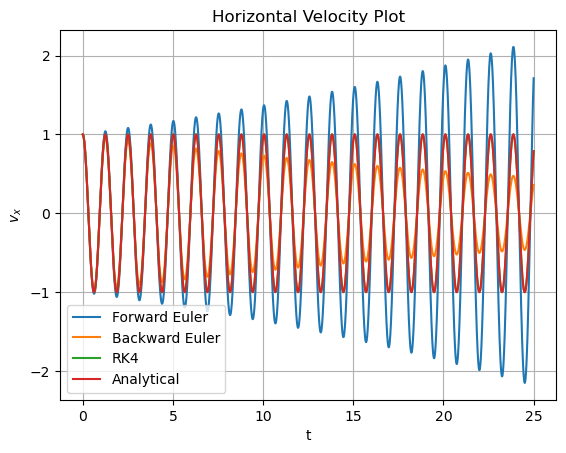

In [8]:
### Make plots of the various v against t
plt.plot(t, v_fwdEuler[:,0], '-', label = 'Forward Euler')
plt.plot(t, v_bwdEuler[:,0], '-', label = 'Backward Euler')
plt.plot(t, v_rk4[:,0], '-', label = 'RK4')
plt.plot(t, analytical_v(t)[0], '-', label = 'Analytical')
plt.grid()
plt.xlabel('t')
plt.ylabel('$v_x$')
plt.legend()
plt.title('Horizontal Velocity Plot')
plt.show()

It's a bit difficult to see, but the velocities in this case are doing what I expect them to.
- The Explicit Euler is gaining energy out of nowhere
- The Backward Euler is losing energy
- The RK4 is matching with the analytical solution very well

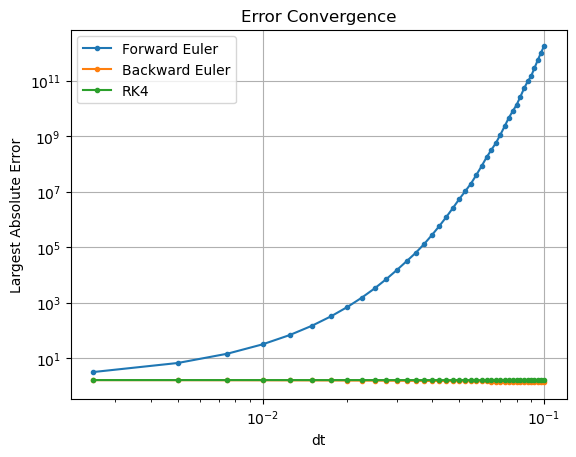

In [9]:
# visualize convergence plot
plt.loglog(dt_vals, Err_vals_fwdEuler, '.-', label = 'Forward Euler')
plt.loglog(dt_vals, Err_vals_bwdEuler, '.-', label = 'Backward Euler')
plt.loglog(dt_vals, Err_vals_rk4, '.-', label = 'RK4')
plt.grid()
plt.xlabel('dt')
plt.ylabel('Largest Absolute Error')
plt.legend()
plt.title('Error Convergence')
plt.show()

The error convergence plot is looking what I would expect it to, aside from the small dip in error for the Backward Euler as $dt$ gets larger- perhaps this is an issue in how I'm getting the error itself. I reckon it should be increasing around the same rate as the Foward Euler, no?

## Time Dependent Field Exercise
Here is my first attempt at a charged particle moving under the influence of an oscillating magnetic field.

In [21]:
sin_bfld = lambda t: B_0 * np.array([0, 0, 8*np.sin(t)])

# Forward Euler
r_fwdEuler, v_fwdEuler, t = explicit_euler(0.01, sim_length, sin_bfld)

# Backward Euler
r_bwdEuler, v_bwdEuler, t = implicit_euler(0.01, sim_length, sin_bfld)

# Rk4
r_rk4, v_rk4, t = rk4(0.01, sim_length, sin_bfld)

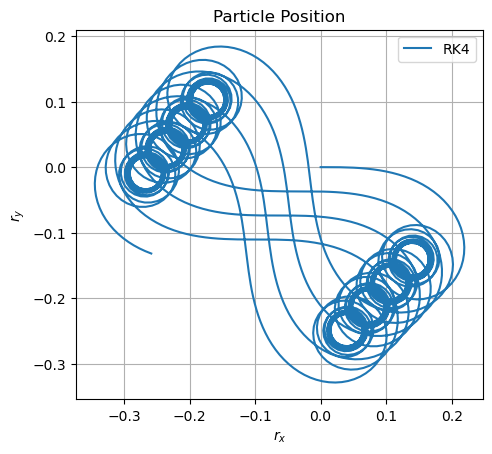

In [22]:
# Plot particle position, using the RK4 as it seems the most stable for this exercise
plt.plot(r_rk4[:, 0], r_rk4[:, 1], '-', label = 'RK4')
plt.grid()
plt.xlabel('$r_x$')
plt.ylabel('$r_y$')
plt.legend()
plt.title('Particle Position')
plt.gca().set_aspect("equal")
plt.show()